### Reading the data

In [1]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

base_dir = "/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet"
df = pd.read_parquet(f'{base_dir}/partition_id=7/part-0.parquet')

df_pl = pl.read_parquet(f'{base_dir}/partition_id=7/part-0.parquet')

### Exploring the data

# Dataset Info

- **79 features and 9 responders**
  - *Anonymized but representing real market data. The training set contains historical data and returns.*

- **date_id** and **time_id**  
  - *Integer values that are ordinally sorted, providing a chronological structure to the data, although the actual time intervals between time_id values may vary.*

- **symbol_id**  
  - *Identifies a unique financial instrument.*

- **weight**  
  - *The weighting used for calculating the scoring function.*

- **feature_{00...78}**  
  - *Anonymized market data.*

- **responder_{0...8}**  
  - *Anonymized responders clipped between -5 and 5. The `responder_6` field is what we are trying to predict.*

### Goal
- Predict `responder_6`.
 responder_6 

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335560 entries, 0 to 6335559
Data columns (total 92 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date_id      int16  
 1   time_id      int16  
 2   symbol_id    int8   
 3   weight       float32
 4   feature_00   float32
 5   feature_01   float32
 6   feature_02   float32
 7   feature_03   float32
 8   feature_04   float32
 9   feature_05   float32
 10  feature_06   float32
 11  feature_07   float32
 12  feature_08   float32
 13  feature_09   int8   
 14  feature_10   int8   
 15  feature_11   int16  
 16  feature_12   float32
 17  feature_13   float32
 18  feature_14   float32
 19  feature_15   float32
 20  feature_16   float32
 21  feature_17   float32
 22  feature_18   float32
 23  feature_19   float32
 24  feature_20   float32
 25  feature_21   float32
 26  feature_22   float32
 27  feature_23   float32
 28  feature_24   float32
 29  feature_25   float32
 30  feature_26   float32
 31  feature_27   float32
 32

In [3]:
empty_columns = []
fully_filled_columns = []
partially_empty_columns = []



## pl
for feature in df_pl.columns:
    # Count empty and non-empty rows
    empty_rows = df_pl[feature].is_null().sum()
    nonempty_rows = len(df_pl[feature]) - empty_rows



    # Classify the columns based on the counts

    if nonempty_rows == 0:
        empty_columns.append(feature)
    elif empty_rows == 0:
        fully_filled_columns.append(feature)
    else:
        partially_empty_columns.append(feature)



    # Print feature statistics
    print(f'{feature} : total - {len(df_pl[feature])} - empty - {empty_rows} - nonempty - {nonempty_rows}')


date_id : total - 6335560 - empty - 0 - nonempty - 6335560
time_id : total - 6335560 - empty - 0 - nonempty - 6335560
symbol_id : total - 6335560 - empty - 0 - nonempty - 6335560
weight : total - 6335560 - empty - 0 - nonempty - 6335560
feature_00 : total - 6335560 - empty - 0 - nonempty - 6335560
feature_01 : total - 6335560 - empty - 0 - nonempty - 6335560
feature_02 : total - 6335560 - empty - 0 - nonempty - 6335560
feature_03 : total - 6335560 - empty - 0 - nonempty - 6335560
feature_04 : total - 6335560 - empty - 0 - nonempty - 6335560
feature_05 : total - 6335560 - empty - 0 - nonempty - 6335560
feature_06 : total - 6335560 - empty - 0 - nonempty - 6335560
feature_07 : total - 6335560 - empty - 0 - nonempty - 6335560
feature_08 : total - 6335560 - empty - 75504 - nonempty - 6260056
feature_09 : total - 6335560 - empty - 0 - nonempty - 6335560
feature_10 : total - 6335560 - empty - 0 - nonempty - 6335560
feature_11 : total - 6335560 - empty - 0 - nonempty - 6335560
feature_12 : to

In [4]:
from IPython.display import display

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also

    display(df.describe().drop(['date_id', 'time_id', 'symbol_id', 'weight'], axis = 1).T.style.background_gradient(cmap='coolwarm'))

,count,mean,std,min,25%,50%,75%,max
feature_00,6335560.000000,1.070064,1.283013,-3.847566,0.121829,0.843269,2.080291,4.598825
feature_01,6335560.000000,0.016119,1.219514,-4.471971,-0.855983,0.071036,0.883402,6.184477
feature_02,6335560.000000,1.071795,1.276411,-2.597594,0.120580,0.840165,2.069826,4.625466
feature_03,6335560.000000,1.071449,1.277353,-3.971338,0.121107,0.840640,2.073104,4.646819
feature_04,6335560.000000,0.006477,1.133789,-4.245502,-0.797053,0.025471,0.816409,4.310173
feature_05,6335560.000000,-0.120161,1.082332,-25.350399,-0.578960,-0.097576,0.357883,28.065392
feature_06,6335560.000000,-0.013713,1.143736,-38.520802,-0.489110,-0.010745,0.453429,46.969715
feature_07,6335560.000000,-0.043206,1.134917,-21.773184,-0.518946,-0.051584,0.415307,54.941608
feature_08,6260056.000000,0.286873,1.094320,-10.963705,-0.256547,0.202659,0.736377,21.695173
feature_09,6335560.000000,32.529870,23.693359,2.000000,11.000000,30.000000,50.000000,82.000000


In [5]:
df[df.date_id==0].symbol_id.unique()
df[df.date_id==1].symbol_id.unique()
df[df.symbol_id == 1].date_id.unique()

set(df[df.symbol_id == 1].date_id.unique()) - set(df[df.symbol_id == 7].date_id.unique())

{1197}

In [6]:
mask1 = (df.symbol_id == 1) & (df.date_id == 0)

mask2 = (df.symbol_id == 7) & (df.date_id == 0)

list(set(df[mask1].time_id.unique()) - set(df[mask2].date_id.unique()))[:10]

[]

### Data Processing

#### Percentage Based Column Filtering

In [7]:
# Sort the DataFrame
# The symbol_id refers to the individual stock. Since this data is chronological. 
# It must be sorted into groups: by stock then day, then time.

df = df.sort_values(by=['symbol_id', 'date_id', 'time_id'])
df = df.reset_index(drop=True)
df.head(100)

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
0,1190,0,0,2.888326,0.928983,0.441290,1.352455,1.301461,2.302733,-0.231061,...,-0.203992,-0.257635,-0.254294,-0.100387,-0.390012,-1.553783,0.224214,-0.278927,-1.170454,0.546211
1,1190,1,0,2.888326,0.812045,0.287618,0.781931,0.862262,1.999738,-0.078465,...,-0.294544,-0.304375,-0.250175,0.242523,-0.562048,-1.679339,0.104258,-0.492223,-2.278074,-0.096518
2,1190,2,0,2.888326,1.564986,0.848806,0.845978,0.934356,2.146238,-0.020378,...,-0.194655,-0.269392,-0.376987,-0.162672,-1.052235,-1.176147,0.202343,-1.118208,-1.336344,0.471153
3,1190,3,0,2.888326,1.646784,0.556938,1.245883,1.384533,2.333363,-0.051726,...,-0.308909,-0.396191,-0.373662,-0.249862,-0.805066,-1.410163,0.085549,-0.550099,-1.818652,0.378067
4,1190,4,0,2.888326,1.048084,0.593710,0.952669,1.393819,1.513835,-0.096590,...,-0.297132,0.057213,-0.049167,0.489998,-0.336325,-1.074370,0.571558,-0.567549,-1.555979,0.374713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1190,95,0,2.888326,0.899313,0.872655,0.611904,0.800270,1.672438,0.091263,...,-0.238560,0.008676,-0.086372,0.032918,-0.112259,-0.088120,-0.338452,-0.069689,0.000172,-0.464786
96,1190,96,0,2.888326,1.152360,0.658832,0.786550,0.733082,1.936692,-0.055169,...,-0.291433,-0.016981,-0.095687,-0.091012,-0.149680,-0.272296,-0.294019,-0.130946,-0.178600,-0.216201
97,1190,97,0,2.888326,0.951265,0.968181,1.005434,0.923703,1.711512,-0.090984,...,-0.235122,-0.006187,-0.098262,-0.108648,-0.178640,-0.211416,-0.172619,-0.174573,-0.113896,-0.192201
98,1190,98,0,2.888326,0.944483,1.020565,0.983124,0.972003,1.554945,-0.003110,...,-0.336540,-0.022539,-0.096584,0.087890,0.077090,-0.070816,0.578915,0.150257,0.004600,0.944588


From the data exploration we saw that each feature column is not completely full. There are random points at which there are NANs or empty datapoints. <br>

Thus, need to be accounted for in some way. <br>

Our method is to process the data frame by stock (symbol_id). Each group contains all the time data (features) for a given stock. Our goal is to check the percentage of missing rows (NANs) for each group and individual feature. <br>

- If a feature for a stock is completely missing we drop the feature for the whole dataframe not just the group/stock.
- If the number of missing rows for a feature of a given stock exceeds a given percentage threshold, then the feature is also dropped for the whole dataframe. In this code the percentage threshold can be easily altered and is arbitrarily set to 10%.
- If there are any empty rows for the feature in that group then we forward and back fill those rows. Since the data is chronologically sorted in the previous step, ffill() and bfill() take the previous or forward time step data. They do not take random data from some other place in time. 
- If there are no empty rows nothing happens

The code uses lists: dropped columns, filled columns, and percent filled. These are used to track the changes to the dataframe and print out the changes made in the data preprocessing for each group. The processed_groups dataframe is used to store the changes of all the groups.

In [8]:
# The processed_groups dataframe is used to store the changes for a given symbol ID.
processed_groups = pd.DataFrame(columns = ['Symbol ID', 'Dropped Columns', 'Filled Columns', '% Filled'])


# The % threshold at which to delete a feature from the whole df.
percentage_threshold = 10.0


# Sorts the df into groups by symbol ID. These are already sorted by time and date in the previous step
for symbol_id, group in df.groupby('symbol_id'):

    # lists to store the changes made to each group
    dropped_columns = []
    filled_columns = []
    percent_filled = []



    for feature in group.columns:

        # calculates percentage of missing rows for a feature in the group
        total_rows = len(group)
        empty_rows = group[feature].isnull().sum()
        empty_rows_percentage = (empty_rows / total_rows) * 100
        nonempty_rows_percentage = 100 - empty_rows_percentage


        # if the feature is empty or the % threshold of missing rows is exceeded --> delete the feature from the df
        if empty_rows == total_rows or empty_rows_percentage >= percentage_threshold:
            df = df.drop(columns=feature)
            
            dropped_columns.append(feature)


        # Forward-fill and backward-fill missing values if lower than threshold and empty rows exist
        elif empty_rows > 0:     
            df.loc[group.index,feature] = group[feature].ffill().bfill()
            
            filled_columns.append(feature)
            percent_filled.append(empty_rows_percentage)







    # Check if there is data to add to the df for a given symbol_id group
    if dropped_columns or filled_columns or percent_filled:

        # new row for table
        new_row = pd.DataFrame({
            'Symbol ID': [symbol_id],
            'Dropped Columns': [dropped_columns],
            'Filled Columns': [filled_columns],
            '% Filled': [percent_filled]
        })
    processed_groups = pd.concat([processed_groups, new_row], ignore_index=True)




print(processed_groups)

   Symbol ID                                   Dropped Columns  \
0          0                                                []   
1          1                                                []   
2          2                                                []   
3          3                                                []   
4          4                                                []   
5          5                                                []   
6          6                                                []   
7          7                                                []   
8          8                                                []   
9          9  [feature_21, feature_26, feature_27, feature_31]   
10        10                                                []   
11        11                                                []   
12        12                                                []   
13        13                                                []   
14        

In [9]:
# This is just a double check if there any missing rows left

null_columns = df.columns[df.isnull().any()]
print(null_columns)

Index([], dtype='object')


#### Normalizing the data

- CHOOSE BETWEEN STANDARD SCALER OR ANOTHER TYPE OF NORMALIZATION

- We must normalize only on the remaining features. Not on time,data,symbol,etc. 

In [10]:
# Normalize just the features

from sklearn.preprocessing import StandardScaler

df_feature_cols = []

# All the possible feature columns in the original data file
possible_feature_cols = [f'feature_{i:02}' for i in range(0,79)]

# Check which features are remaining after the preprocessing
for feature in df.columns:
    if feature in possible_feature_cols:
        df_feature_cols.append(feature)


# Normalize only on the remaining features
std_scaler = StandardScaler()
df[df_feature_cols] = std_scaler.fit_transform(df[df_feature_cols])

#### One Hot Encoding

Numeric representation doesn't imply order:
- Symbol_id is a categorical variable. Thus the numeric value of symbol_id does not have a meaningful order (e.g., 1, 2, 3 aren't inherently "larger" or "smaller").

One Hot Encoding avoids misinterpretation by the model:
- Using raw numeric values could mislead the model into interpreting the column as continuous (e.g., implying a distance between symbol_id = 1 and symbol_id = 2). One-Hot Encoding converts categorical variables into binary indicators that can be safely used in machine learning models.

In [11]:
encoded = pd.get_dummies(df['symbol_id'], prefix='symbol_id')

max_symbol_id = df['symbol_id'].max()

print(max_symbol_id)

encoded.head()

38


,symbol_id_0,symbol_id_1,symbol_id_2,symbol_id_3,symbol_id_4,symbol_id_5,symbol_id_6,symbol_id_7,symbol_id_8,symbol_id_9,...,symbol_id_29,symbol_id_30,symbol_id_31,symbol_id_32,symbol_id_33,symbol_id_34,symbol_id_35,symbol_id_36,symbol_id_37,symbol_id_38
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [12]:
df = pd.concat([df, encoded], axis = 1)

df = df.drop(['symbol_id'], axis = 1)

df.head()

,date_id,time_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,...,symbol_id_29,symbol_id_30,symbol_id_31,symbol_id_32,symbol_id_33,symbol_id_34,symbol_id_35,symbol_id_36,symbol_id_37,symbol_id_38
0,1190,0,2.888326,-0.109961,0.348639,0.219882,0.180069,2.025294,-0.102465,0.238417,...,False,False,False,False,False,False,False,False,False,False
1,1190,1,2.888326,-0.201104,0.222629,-0.227093,-0.163766,1.758053,0.038524,1.119322,...,False,False,False,False,False,False,False,False,False,False
2,1190,2,2.888326,0.385749,0.682802,-0.176916,-0.107326,1.887265,0.092192,1.162381,...,False,False,False,False,False,False,False,False,False,False
3,1190,3,2.888326,0.449504,0.443471,0.136389,0.245104,2.052309,0.063229,0.387986,...,False,False,False,False,False,False,False,False,False,False
4,1190,4,2.888326,-0.017132,0.473624,-0.093329,0.252373,1.329487,0.021778,0.235756,...,False,False,False,False,False,False,False,False,False,False


#### Temporal Splitting

In [13]:
df = df.sort_values(['date_id', 'time_id'])
date_counts = df.date_id.value_counts()

In [14]:
date_counts = pd.DataFrame(date_counts.sort_index())
date_counts['cumulative_sum'] = date_counts['count'].cumsum()
date_counts.head()

,count,cumulative_sum
date_id,,
1190,37752,37752
1191,36784,74536
1192,36784,111320
1193,37752,149072
1194,30976,180048


In [15]:
total = len(df)
train_percentage = 0.6
val_percentage = 0.2
test_percentage = 0.2

apprx_train_len = int(total*train_percentage)
apprx_val_len = int(total*val_percentage)
apprx_test_len = total - apprx_train_len - apprx_val_len



def split_func(row):
    s = row['cumulative_sum']
    
    if s <= apprx_train_len:
        return 'Train'

    elif (s > apprx_train_len) and (s <= apprx_train_len + apprx_val_len):
        return 'Val'

    elif (s > apprx_train_len + apprx_val_len):
        return 'Test'

    else:
        raise ValueError



date_counts['Split'] = date_counts.apply(split_func, axis = 1)
print(date_counts.Split.value_counts())
date_counts.head()

Split
Train    102
Val       34
Test      34
Name: count, dtype: int64


,count,cumulative_sum,Split
date_id,,,
1190,37752,37752,Train
1191,36784,74536,Train
1192,36784,111320,Train
1193,37752,149072,Train
1194,30976,180048,Train


In [16]:
last_train_data = date_counts[date_counts.Split == 'Train'].tail(1)

first_test_data = date_counts[date_counts.Split == 'Test'].head(1)


# it fails here

In [17]:
%%time

# def split_func_df(row):

#     s = row['date_id']

#     if s <= last_train_data.index[0]:

#         return 'Train'

#     elif (s > last_train_data.index[0]) and (s < first_test_data.index[0]):

#         return 'Val'

#     elif (s >= first_test_data.index[0]):

#         return 'Test'

#     else:

#         raise ValueError





# df['Split'] = df.apply(split_func_df, axis = 1)

# df['Split'].value_counts()

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 9.78 µs


In [18]:
# last_train_index = last_train_data.index[0]
# first_test_index = first_test_data.index[0]

# if df['date_id'] <= last_train_index:
#     df['Split'] = 'Train'
# elif (df['date_id'] > last_train_index) and (df['date_id'] < first_test_index):
#     df['Split'] = 'Val'
# else:
#     df['Split'] = 'Test'


# print(df['Split'].value_counts())


In [19]:
last_train_index = last_train_data.index[0]
first_test_index = first_test_data.index[0]


df['Split'] = 'Test'
df.loc[df['date_id'] <= last_train_index, 'Split'] = 'Train'
df.loc[(df['date_id'] > last_train_index) & (df['date_id'] < first_test_index), 'Split'] = 'Val'

print(df['Split'].value_counts())

Split
Train    3783912
Test     1277760
Val      1273888
Name: count, dtype: int64


In [20]:
train_df = df[df.Split == 'Train']
val_df = df[df.Split == 'Val']
test_df = df[df.Split == 'Test']

#### Setting the features

In [21]:
TEMPORAL_FEATURES = ['date_id', 'time_id','symbol_id']

MARKET_FEATURES = [f'feature_{i:02}' for i in range(0,79) if f'feature_{i:02}' in df.columns]

RESPONDER_FEATURES = [f'responder_{i}' for i in range(0,9) if f'responder_{i}' in df.columns]

RESPONDER_FEATURES.remove('responder_6')

SYMBOL_FEATURES = [f'symbol_id_{i}' for i in range(max_symbol_id) if f'symbol_id_{i}' in df.columns]

WEIGHT = ['WEIGHT']

In [22]:
ALL_FEATURES = MARKET_FEATURES
ALL_FEATURES += RESPONDER_FEATURES
ALL_FEATURES = ALL_FEATURES + SYMBOL_FEATURES

In [23]:
train_x = train_df[ALL_FEATURES]
train_y = train_df[['responder_6']]

val_x = val_df[ALL_FEATURES]
val_y = val_df[['responder_6']]

test_x = test_df[ALL_FEATURES]
test_y = test_df[['responder_6']]

# Models

## TO DO
- create global dataframe with model name and MSE results. This will allow for a table at the end with the results of all the models so that we can compare them

- COMMENT CODE

- explain each model before the cooresponding code block
- explain each model output and behavior


In [24]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

### Ridge Regression

Penalty: Squares the magnitude of the coefficients in loss function <br>


Cost Function:J(β) = RSS + α ∑βᵢ^2

Where:

- RSS is the Residual Sum of Squares (error term).
- βₖ are the model's coefficients.
- α controls the strength of the penalty. Larger α forces coefficients closer to zero.

Behavior:
- Penalizes large coefficients by squaring them.
- Reduces multicollinearity (correlation between predictors).
- Keeps all features but shrinks their coefficients towards zero.
- Best for situations where many predictors are useful.

We want to use ridge regression because it works best when features are important and multicollinearity is present. Since we have unlabeled financial data we don't want to do extra feature selection. We also expect some form of multicollinearity between the results. ridge regression also works best when overfitting is a concern and feature elimination is not desired.

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.38086e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.15889e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.50121e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


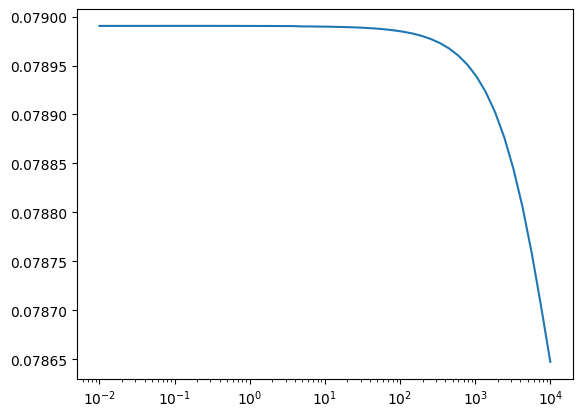

Minimum MSE = 0.07864727079868317 at alpha = 10000.0


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np


ridge_mse = []

# Ridge Regression
# Typical values of alpha are 0.01 to 10,000
# 50 alpha values from 0.01 to 10000 in logarithmic scaling
alpha_counter = np.logspace(-2, 4, 50)


for a in alpha_counter:
    ridge = Ridge(alpha=a)
    ridge.fit(train_x, train_y)
    ridge_y_pred = ridge.predict(test_x)
    ridge_mse.append(mean_squared_error(test_y, ridge_y_pred))
    del ridge



plt.plot(alpha_counter,ridge_mse)
plt.xscale('log')
plt.show()



# argmin() finds index of minimnum value
min_mse_index = np.argmin(ridge_mse)
print(f'Minimum MSE = {ridge_mse[min_mse_index]} at alpha = {alpha_counter[min_mse_index]}')

### Lasso Regression



Penalty: Takes the absolute value of the coefficients in loss function <br>


Cost Function:J(β) = RSS + α ∑ |βᵢ|

Behavior:
- Penalizes large coefficients by their absolute values.
- Performs feature selection: can set some coefficients to exactly 0, effectively removing irrelevant features.
- Best for situations where only a subset of predictors is relevant

In [ ]:
lasso_mse = []
Lalpha_counter = np.logspace(-3, 1, 50)


for a in Lalpha_counter:
    lasso = Lasso(alpha=a)
    lasso.fit(train_x, train_y)
    lasso_y_pred = lasso.predict(test_x)
    lasso_mse.append(mean_squared_error(test_y, lasso_y_pred))


plt.plot(Lalpha_counter,lasso_mse)
plt.xscale('log')
plt.show()



# argmin() finds index of minimnum value
min_mse_index = np.argmin(lasso_mse)
print(f'Minimum MSE = {lasso_mse[min_mse_index]} at alpha = {Lalpha_counter[min_mse_index]}')

### Checking Elastic Results

Elastic Regression combines both Ridge and Lasso Regression


Cost Function:J(β) = RSS + α1 ∑βᵢ^2 + α2 ∑ |βᵢ|

Behavior:
- Hybrid approach: Balances feature selection (Lasso) and coefficient shrinkage (Ridge).
- Useful when there are multiple correlated features, and Lasso struggles to choose one.


In [ ]:
l1_alpha_values = np.logspace(-3, 2, 10)  # 10 values from 0.001 to 100
l1_ratios = np.linspace(0.1, 1.0, 10)  # 10 values from 0.1 to 1.0


elastic_mse_results = np.zeros((len(l1_alpha_values), len(l1_ratios)))


for i, a in enumerate(l1_alpha_values):
    for j, l1 in enumerate(l1_ratios):
        elastic_net = ElasticNet(alpha=a, l1_ratio=l1)
        elastic_net.fit(train_x, train_y)
        elastic_net_y_pred = elastic_net.predict(test_x)
        elastic_mse_results[i, j] = mean_squared_error(test_y, elastic_net_y_pred)







min_mse_index = np.unravel_index(np.argmin(elastic_mse_results, axis=None), elastic_mse_results.shape)
optimal_alpha = l1_alpha_values[min_mse_index[0]]
optimal_l1_ratio = l1_ratios[min_mse_index[1]]



print(f"Optimal Alpha: {optimal_alpha}")
print(f"Optimal L1 Ratio: {optimal_l1_ratio}")
print(f"Minimum MSE: {elastic_mse_results[min_mse_index]}")

### Decision Trees and XGBoost

In [ ]:
# Import libraries

from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import LinearRegression

import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score



# Models for regression

regressors = {

    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42),

    "Linear Regression": LinearRegression(),

    "XGBoost": xgb.XGBRegressor(tree_method="hist")

}



# Metrics for regression

metrics = {

    "Mean Squared Error": mean_squared_error,

    "Mean Absolute Error": mean_absolute_error,

    "R^2 Score": r2_score,

    "Explained Variance": explained_variance_score

}

In [ ]:
import time



use_val = True

results_train = {}

results_val = {}



for model in regressors:

    print(f"Model: {model}")



    # Start timing

    start_time = time.time()



    # Train the model

    regressors[model].fit(train_x, train_y)



    # End timing

    end_time = time.time()

    elapsed_time = end_time - start_time



    # Predict and calculate metrics

    pred_y = regressors[model].predict(train_x)

    if use_val:

        pred_y_val = regressors[model].predict(val_x)



    train_list = []

    val_list = []

    for metric in metrics:

        score = metrics[metric](train_y, pred_y)

        result_string = f"{metric}: Train - {round(score, 4)}"

        if use_val:

            score2 = metrics[metric](val_y, pred_y_val)

            result_string+= f" Val - {round(score2,4)}"

            val_list.append(score2)

        print(result_string)

        train_list.append(score)



    # Save results

    results_train[model] = train_list

    if use_val:

        results_val[model] = val_list



    # Print elapsed time

    print(f"Time taken: {elapsed_time:.2f} seconds")

    print()

#### Neural Nets

In [25]:
import tensorflow as tf



tf.keras.backend.clear_session()

tf.random.set_seed(42)

In [26]:
input_shape=train_x.shape[1:]

print(input_shape)

(121,)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


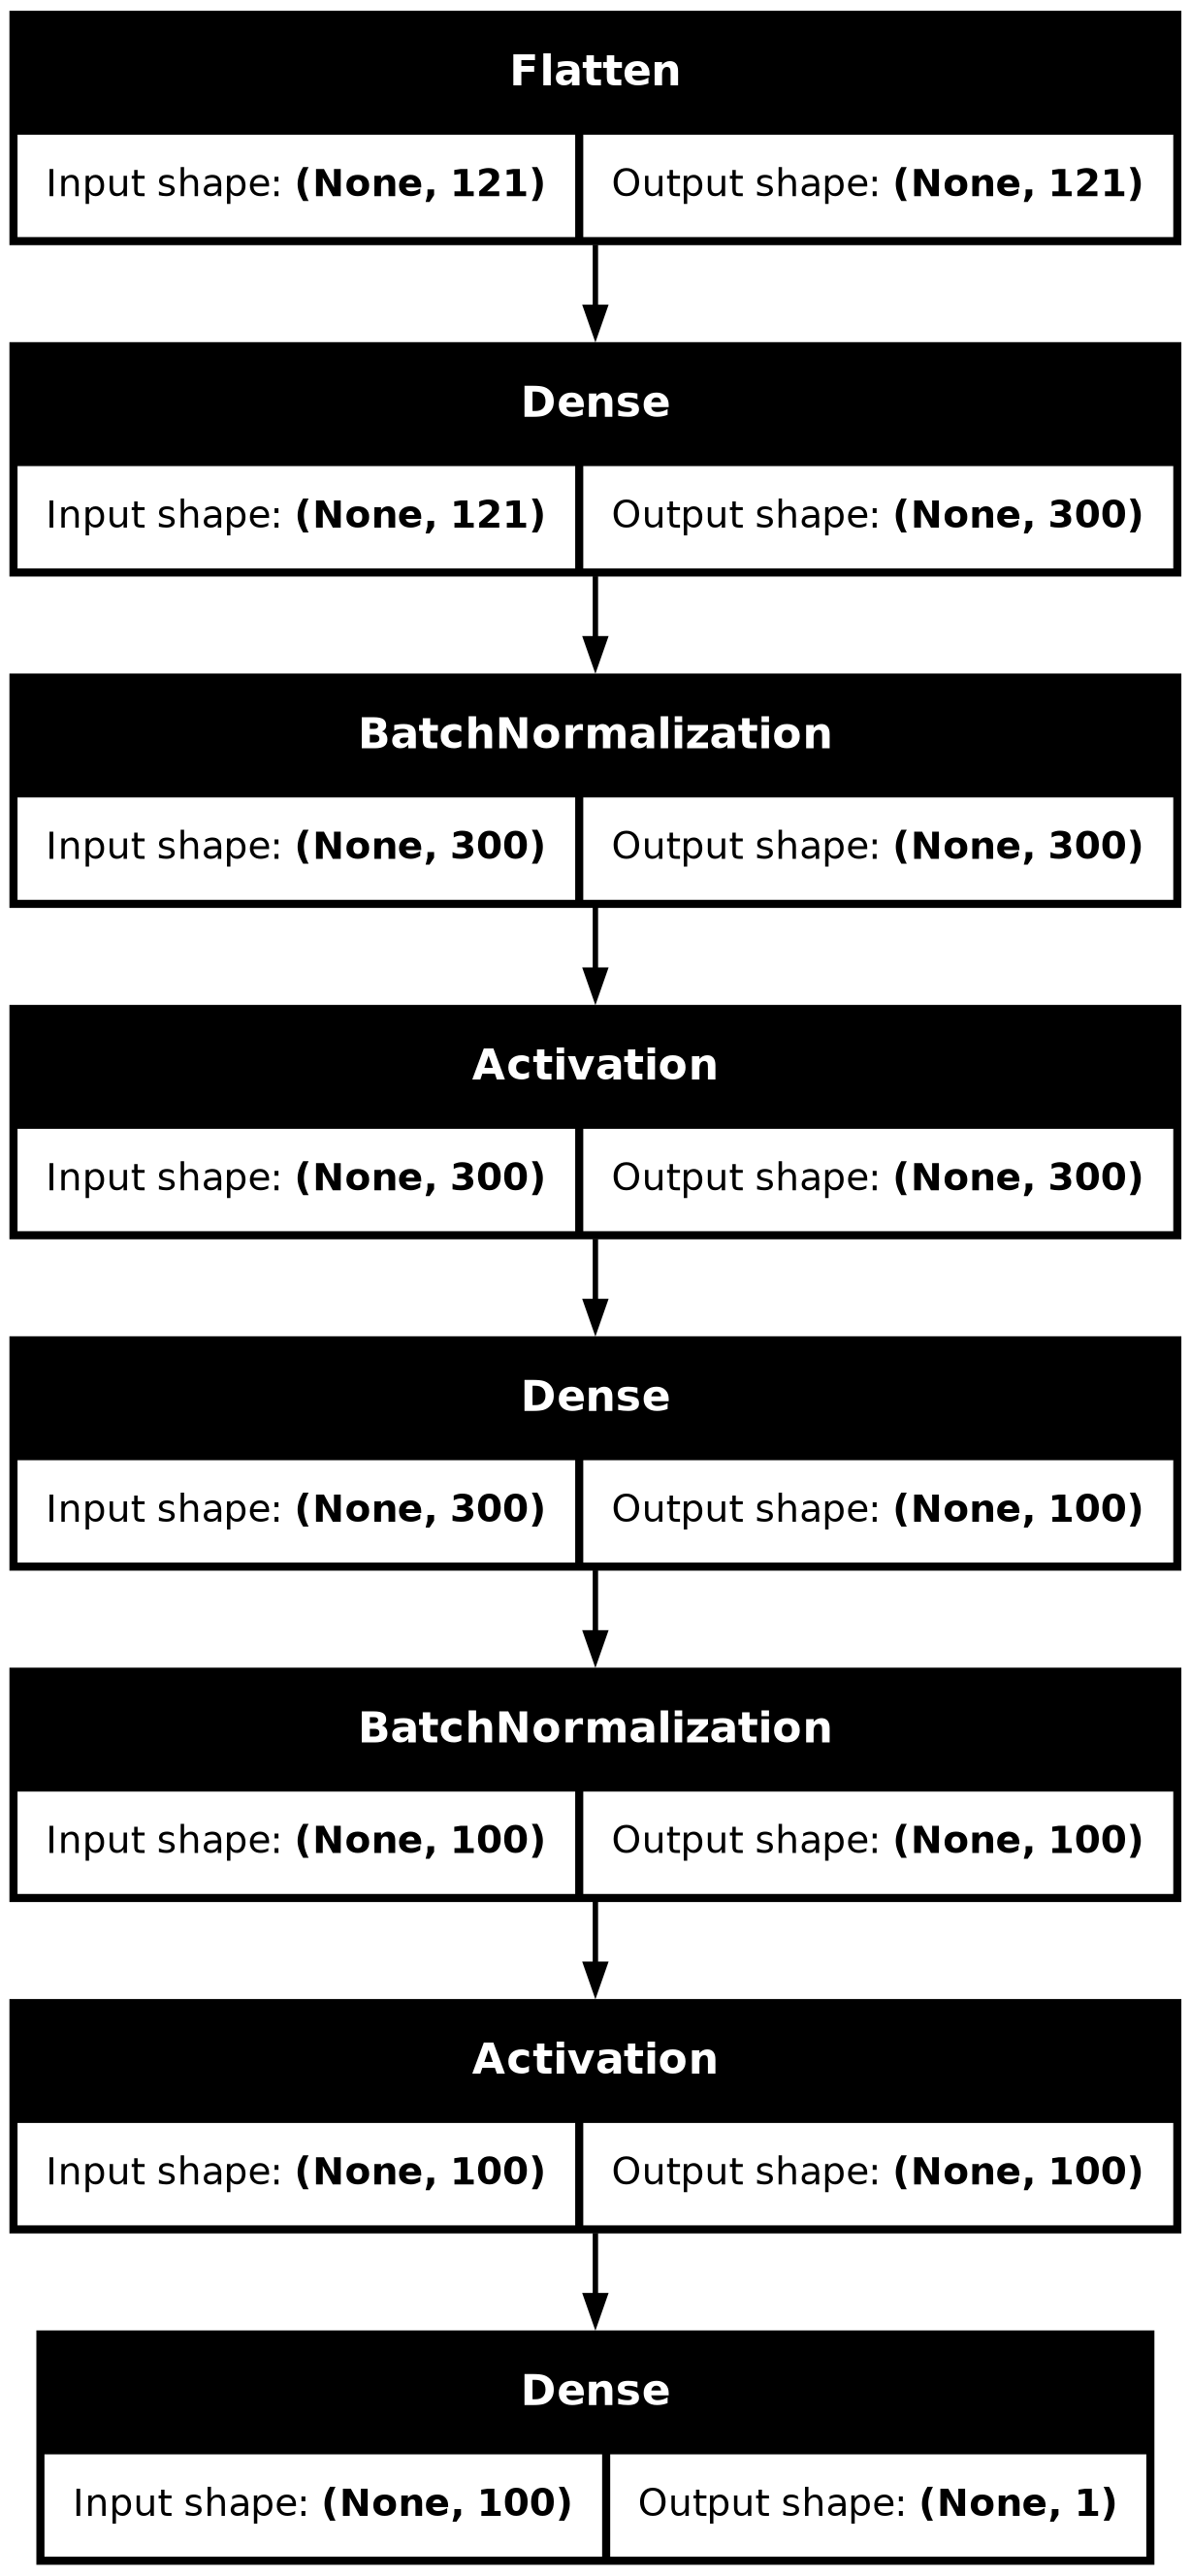

In [27]:
model = tf.keras.Sequential([

    tf.keras.layers.Flatten(input_shape=input_shape),

    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),

    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),

    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Activation("relu"),



    # Single output neuron for regression

    # We want to predict just Responder_6

    tf.keras.layers.Dense(1, activation=None)

])



tf.keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [ ]:
model.compile(loss="mse",
              optimizer="adam",
              metrics=["mse", "mae"])

history = model.fit(train_x.values.astype('float32'), train_y.values.astype('float32'),

                             batch_size = 1024,

                             validation_data = (val_x.values.astype('float32'), val_y.values.astype('float32')) if use_val else None,

                             epochs=3)

In [ ]:
pd.DataFrame(history.history).plot(

    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",

    style=["r--", "r--.", "b-", "b-*"])

plt.legend(loc="lower left")  # extra code

plt.show()

In [ ]:
test_x = test_df[ALL_FEATURES]

test_y = test_df[['responder_6']]

In [ ]:
pred_y_test = regressors[model].predict(test_x.values.astype('float32'), batch_size = 1024)

In [ ]:
# Performance

results_test = {}

for model in regressors:

  print(f"Model: {model}")

  if 'Neural Net' in model:

      pred_y_test = regressors[model].predict(test_x.values.astype('float32'),

                                             batch_size = 1024)

  else:

      pred_y_test = regressors[model].predict(test_x)



  results = []

  for metric in metrics:

    score = metrics[metric](test_y, pred_y_test)

    print(f"{metric}: {round(score,4)}")

    results.append(score)

  results_test[model] = results



  print()

### Feature Importance

In [ ]:
from xgboost import plot_importance

plt.figure(figsize = (10,20))



plot_importance(regressors["XGBoost"])

plt.savefig('feature_importance.png', dpi = 300)